RANDOM CROSS VALIDATION

In [1]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
import xarray as xr

nh3_nc = xr.load_dataset('../datasets/CAMS-GLOB-ANT_Glb_0.1x0.1_anthro_nh3_v4.2_monthly_lombardia.nc') # Copernicus (0.1°x0.1°)

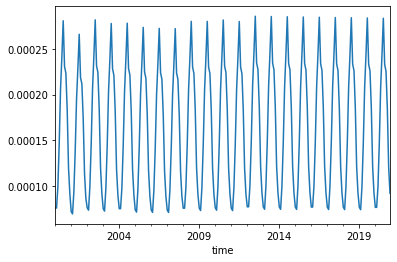

In [3]:
from utils import utils
import matplotlib.pyplot as plt

nh3 = utils.xarray2pandas(nh3_nc.agl, 6, 17).to_period('M')
nh3.plot()
plt.show()

In [4]:
import random

random.seed(0)

def random_training_validation_window(ts, size, validation_size):

    n = len(ts)

    start = random.randint(0, int(n*(1-size)) - validation_size)
    end = start + int(n*size)
    return ts[start:end], ts[end:end+validation_size]

In [5]:
def multiple_forecasts(model, ts, times, refit=False):
    
    predictions = []
    errors = []

    for i in range(len(ts)):
        prediction = model.forecast()
        model = model.append([prediction.values[0]], refit=refit)
        predictions.append(prediction.values[0])
        errors.append(ts.values[i] - prediction.values[0])
    
    return predictions, errors

In [6]:
def autocorr(ts):
    errors = pd.Series(ts)
    n = len(ts)
    data = np.asarray(ts)
    mean = np.mean(data)
    c0 = np.sum((data - mean) ** 2) / float(n)

    def r(h):
        return ((data[:n - h] - mean) * (data[h:] - mean)).sum() / float(n) / c0

    lags = np.arange(n) + 1
    return list(map(r, lags))

In [7]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
import pandas as pd

def random_cross_validation(ts, order, seasonal_order, times=1, verbose=False):

    aics = []
    bics = []
    rmses = []
    sses = []
    mses = []
    year_autocorrs_out_of_sample = []
    is_correct = True

    for i in range(times):
        train_months = 180
        validation_months = 12
        train_data, validation_data = random_training_validation_window(nh3, train_months/len(nh3), validation_months)

        assert(len(train_data) == train_months)
        assert(len(validation_data) == validation_months)

        model = ARIMA(endog=train_data, order=order, seasonal_order=seasonal_order).fit()

        aics.append(model.aicc)
        bics.append(model.bic)

        # out of sample
        predictions, errors = multiple_forecasts(model=model, ts=validation_data, times=len(validation_data), refit=False)
        rmse = np.sqrt(np.mean(((predictions - validation_data.values) ** 2)))
        rmses.append(rmse)

        sses.append(model.sse)
        mses.append(model.mse)

        # autocorrelation at lag=12
        year_autocorrs_out_of_sample.append(autocorr(model.resid)[12])

    return np.mean(rmses), np.mean(aics), np.mean(bics), np.mean(sses),  np.mean(mses), np.mean(np.abs(acf(model.resid))), np.mean(np.abs(year_autocorrs_out_of_sample))

In [8]:
# SARIMAX(p,d,q,P,D,Q,s)

import numpy as np
from statsmodels.tsa.stattools import acf

def model_selection(ts, cv_iterations=1, verbose=False):
    
    p_list = [1,2,3,4,5,6,7,8,9,10,11, [1,2,5,6], [1,6], [1,5,6]]
    q_list = [0,1,2]
    P_list = [1]
    Q_list = [0, 1]
    s_list = [12]

    results = {}
    idx = 0

    for p in p_list:
       for q in q_list:
            for P in P_list:
                for Q in Q_list:
                    for s in s_list:
                        model_name = 'SARIMA(p={}, d=0, q={}, P={}, D=0, Q={}, s={})'.format(p, q, P, Q, s)
                        model_idx = idx

                        if verbose: print('{}: {}'.format(model_idx, model_name))
                        
                        rmse, aic, bic, sse, mse, meaacf, yac_out_of_sample = random_cross_validation(ts=ts, order=(p,0,q), seasonal_order=(P,0,Q,s), times=cv_iterations)

                        results[model_name] = {
                            'order' : (p,0,q),
                            'seasonal_order' : (P,0,Q,s),
                            'aic' : aic,
                            'bic' : bic,
                            'sse' : sse,
                            'rmse' : rmse,
                            'mse' : mse,
                            'index' : model_idx,
                            'mean_abs_acf': meaacf,
                            'yac_out_of_sample': yac_out_of_sample   
                            }

                        idx += 1
                    
                    
    return results

In [9]:
results = model_selection(nh3, cv_iterations=1, verbose=True)

0: SARIMA(p=1, d=0, q=0, P=1, D=0, Q=0, s=12)
1: SARIMA(p=1, d=0, q=0, P=1, D=0, Q=1, s=12)
2: SARIMA(p=1, d=0, q=1, P=1, D=0, Q=0, s=12)
3: SARIMA(p=1, d=0, q=1, P=1, D=0, Q=1, s=12)
4: SARIMA(p=1, d=0, q=2, P=1, D=0, Q=0, s=12)
5: SARIMA(p=1, d=0, q=2, P=1, D=0, Q=1, s=12)
6: SARIMA(p=2, d=0, q=0, P=1, D=0, Q=0, s=12)
7: SARIMA(p=2, d=0, q=0, P=1, D=0, Q=1, s=12)
8: SARIMA(p=2, d=0, q=1, P=1, D=0, Q=0, s=12)
9: SARIMA(p=2, d=0, q=1, P=1, D=0, Q=1, s=12)
10: SARIMA(p=2, d=0, q=2, P=1, D=0, Q=0, s=12)
11: SARIMA(p=2, d=0, q=2, P=1, D=0, Q=1, s=12)
12: SARIMA(p=3, d=0, q=0, P=1, D=0, Q=0, s=12)
13: SARIMA(p=3, d=0, q=0, P=1, D=0, Q=1, s=12)
14: SARIMA(p=3, d=0, q=1, P=1, D=0, Q=0, s=12)
15: SARIMA(p=3, d=0, q=1, P=1, D=0, Q=1, s=12)
16: SARIMA(p=3, d=0, q=2, P=1, D=0, Q=0, s=12)
17: SARIMA(p=3, d=0, q=2, P=1, D=0, Q=1, s=12)
18: SARIMA(p=4, d=0, q=0, P=1, D=0, Q=0, s=12)
19: SARIMA(p=4, d=0, q=0, P=1, D=0, Q=1, s=12)
20: SARIMA(p=4, d=0, q=1, P=1, D=0, Q=0, s=12)
21: SARIMA(p=4, d=0, q=

In [10]:
aics = [v['aic'] for k, v in results.items()]
bics = [v['bic'] for k, v in results.items()]
rmses = [v['rmse'] for k, v in results.items()]
sses = [v['sse'] for k, v in results.items()]
mses = [v['mse'] for k, v in results.items()]
maacf = [v['mean_abs_acf'] for k, v in results.items()]
yac_out_of_sample = [v['yac_out_of_sample'] for k, v in results.items()]

In [11]:
def tick(order, seasonal_order):
    p, d, q = order
    P, D, Q, s = seasonal_order
    return str((p,q,P,Q))

ticks = [tick(v['order'], v['seasonal_order']) for k, v in sorted(results.items(), key=lambda item: item[1]['index'])]

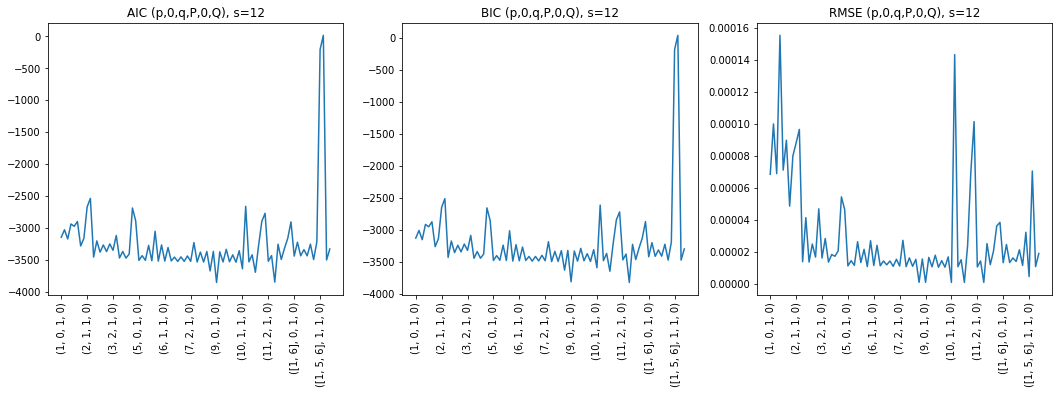

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
indices = np.arange(0, len(results), 8)

axs[0].plot(aics)
axs[0].set_title('AIC (p,0,q,P,0,Q), s=12')
axs[0].set_xticks(indices)
axs[0].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[1].plot(bics)
axs[1].set_title('BIC (p,0,q,P,0,Q), s=12')
axs[1].set_xticks(indices)
axs[1].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[2].plot(rmses)
axs[2].set_title('RMSE (p,0,q,P,0,Q), s=12')
axs[2].set_xticks(indices)
axs[2].set_xticklabels(np.array(ticks)[indices], rotation=90)

plt.show()

In [13]:
print('min AIC: {}, min BIC {}, min RMSE {}'.format(np.argmin(aics), np.argmin(bics), np.argmin(rmses)))

min AIC: 48, min BIC 66, min RMSE 56


In [14]:
min_aic_model = [v for k,v in results.items() if v['aic'] == np.min(aics)][0]
min_aic_model

{'order': (9, 0, 0),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3852.51984411117,
 'bic': -3816.0726253735415,
 'sse': 7.550270139430184e-09,
 'rmse': 7.98487484933737e-07,
 'mse': 4.194594521905658e-11,
 'index': 48,
 'mean_abs_acf': 0.08478975025688744,
 'yac_out_of_sample': 0.004116159806448128}

In [15]:
min_bic_model = [v for k,v in results.items() if v['bic'] == np.min(bics)][0]
min_bic_model

{'order': ([1, 2, 5, 6], 0, 0),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3847.554149433659,
 'bic': -3825.854614268125,
 'sse': 1.6895689802655933e-08,
 'rmse': 7.918329409813828e-07,
 'mse': 9.386494334808851e-11,
 'index': 66,
 'mean_abs_acf': 0.108031514905432,
 'yac_out_of_sample': 0.10824475230242349}

In [16]:
min_rmse_model = [v for k,v in results.items() if v['rmse'] == np.min(rmses)][0]
min_rmse_model

{'order': (10, 0, 1),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3637.84643345324,
 'bic': -3595.6904920862316,
 'sse': 8.133085665212631e-09,
 'rmse': 7.430472706252117e-07,
 'mse': 4.5183809251181284e-11,
 'index': 56,
 'mean_abs_acf': 0.10037435433710276,
 'yac_out_of_sample': 0.026822342754324758}

In [17]:
min_sse_model = [v for k,v in results.items() if v['sse'] == np.min(sses)][0]
min_sse_model

{'order': (9, 0, 0),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3852.51984411117,
 'bic': -3816.0726253735415,
 'sse': 7.550270139430184e-09,
 'rmse': 7.98487484933737e-07,
 'mse': 4.194594521905658e-11,
 'index': 48,
 'mean_abs_acf': 0.08478975025688744,
 'yac_out_of_sample': 0.004116159806448128}

In [18]:
min_mse_model = [v for k,v in results.items() if v['mse'] == np.min(mses)][0]
min_mse_model

{'order': (9, 0, 0),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3852.51984411117,
 'bic': -3816.0726253735415,
 'sse': 7.550270139430184e-09,
 'rmse': 7.98487484933737e-07,
 'mse': 4.194594521905658e-11,
 'index': 48,
 'mean_abs_acf': 0.08478975025688744,
 'yac_out_of_sample': 0.004116159806448128}

In [19]:
min_abs_acf_model = [v for k,v in results.items() if v['mean_abs_acf'] == np.min(maacf)][0]
min_abs_acf_model

{'order': (9, 0, 0),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3852.51984411117,
 'bic': -3816.0726253735415,
 'sse': 7.550270139430184e-09,
 'rmse': 7.98487484933737e-07,
 'mse': 4.194594521905658e-11,
 'index': 48,
 'mean_abs_acf': 0.08478975025688744,
 'yac_out_of_sample': 0.004116159806448128}

In [20]:
min_yac_out_of_sample_model = [v for k,v in results.items() if v['yac_out_of_sample'] == np.min(yac_out_of_sample)][0]
min_yac_out_of_sample_model

{'order': (9, 0, 2),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3528.7414654647114,
 'bic': -3486.585524097703,
 'sse': 2.962732248335176e-08,
 'rmse': 1.0241240285888606e-05,
 'mse': 1.6459623601862087e-10,
 'index': 52,
 'mean_abs_acf': 0.17871779917767766,
 'yac_out_of_sample': 0.00409513779511481}

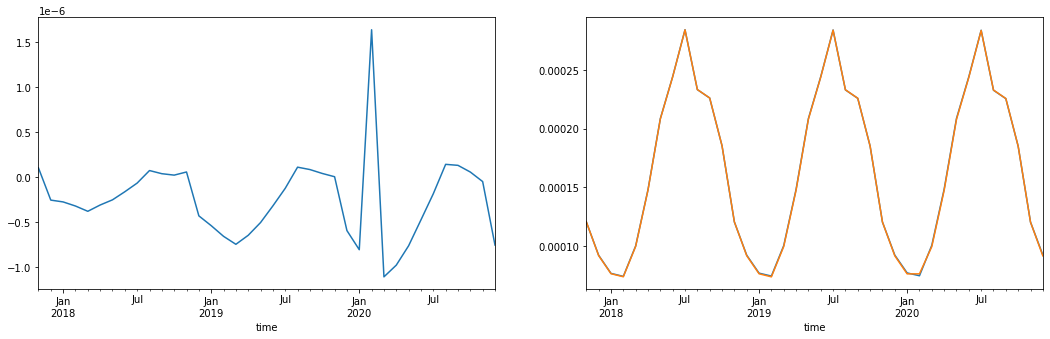

In [37]:
import pandas as pd

train_data, validation_data = utils.ts_train_test_split(nh3, .85)
validation_data = validation_data

best_model = ARIMA(train_data, order=min_aic_model['order'], seasonal_order=min_aic_model['seasonal_order']).fit()
predictions, errors = multiple_forecasts(model=best_model, ts=validation_data, times=len(validation_data), refit=False)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

pd.Series(errors, index=validation_data.index).plot(ax=axs[0])

pd.Series(predictions, index=validation_data.index).plot(ax=axs[1])
validation_data.plot(ax=axs[1])
plt.show()

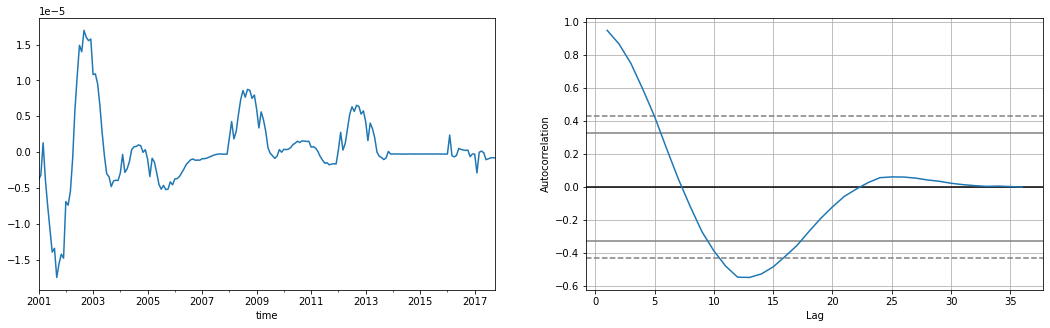

In [38]:
from pandas.plotting import autocorrelation_plot

errors = best_model.resid

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

pd.Series(errors[12:]).plot(ax=axs[0])
autocorrelation_plot(errors[12:48], ax=axs[1])
plt.show()

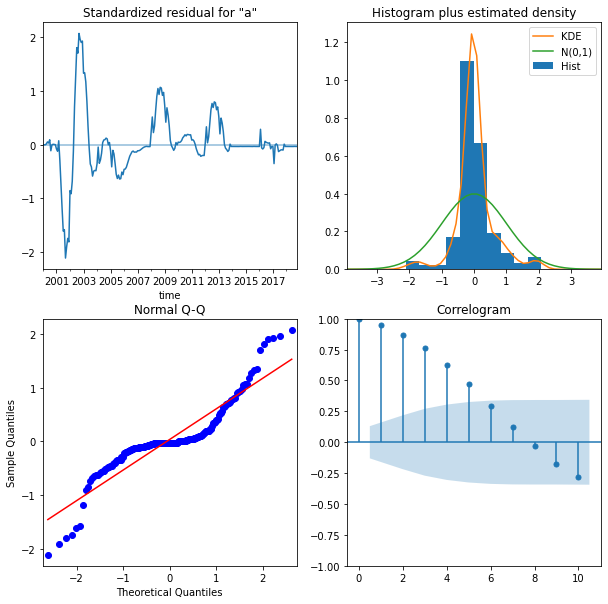

In [23]:
best_model.plot_diagnostics(figsize=(10,10))
plt.show()

Excluding the first 12 months due to seasonality

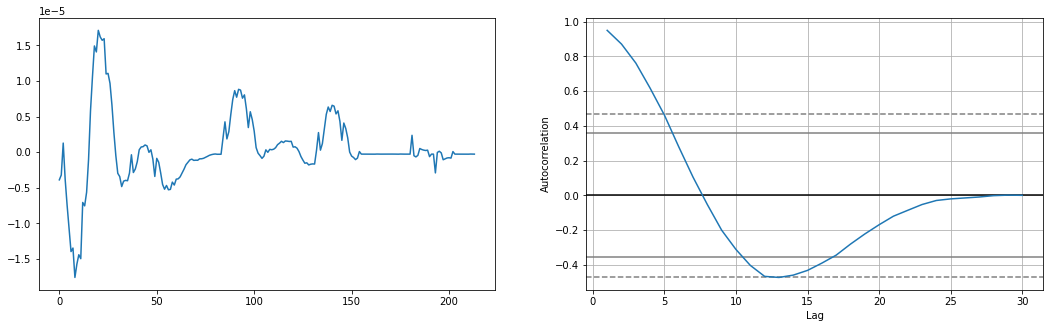

In [24]:
predictions = best_model.predict(start=train_data.index[12], end=train_data.index[-1])

errors = train_data[12:].values - predictions.values

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

pd.Series(errors).plot(ax=axs[0])
autocorrelation_plot(errors[:30], ax=axs[1])
plt.show()

In [25]:
#  null hypothesis is of no heteroskedasticity

result = best_model.test_heteroskedasticity(method=None)
if result[0, 1] < 0.05: print('Eteroschedastici')
result

Eteroschedastici


array([[6.53255989e-02, 1.25838171e-25]])

In [26]:
best_model.test_normality('jarquebera')

array([[1.62898878e+02, 4.23601992e-36, 2.96758692e-01, 7.11664099e+00]])

In [27]:
print(best_model.pvalues)

const       0.788921
ar.L1       0.000000
ar.L2       0.000000
ar.L3       0.000000
ar.L4       0.000000
ar.L5       0.000000
ar.L6       0.000000
ar.L7       0.000000
ar.L8       0.000000
ar.L9       0.000000
ar.S.L12    0.000000
sigma2      0.613814
dtype: float64


In [28]:
best_model.params

const       1.640950e-04
ar.L1       8.710073e-02
ar.L2       1.505133e-01
ar.L3       6.625277e-02
ar.L4      -2.990015e-01
ar.L5      -2.473554e-01
ar.L6      -2.083131e-01
ar.L7      -1.923923e-01
ar.L8      -2.110719e-01
ar.L9       1.344127e-01
ar.S.L12    9.994206e-01
sigma2      6.823492e-11
dtype: float64

In [29]:
best_model.test_serial_correlation('boxpierce', lags=12)[0][1]

array([5.15170056e-046, 8.14844532e-082, 4.51788199e-109, 6.88326453e-127,
       1.72548482e-136, 1.25672850e-139, 2.61976425e-139, 2.35408503e-138,
       7.20092493e-139, 7.74594836e-142, 1.12315936e-147, 3.82728307e-156])

In [30]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(errors, model_df=len(best_model.param_names)-1)[1]

array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan, 2.42868491e-164,
       1.58588177e-172, 3.20722727e-180, 8.61535786e-187, 1.27722476e-191,
       1.24927467e-194, 7.54351935e-196, 8.94429959e-196, 5.04014654e-195,
       5.15650067e-194, 4.68303162e-193, 2.78973705e-192, 1.05538153e-191,
       3.97887545e-191, 2.10546098e-190, 1.42305303e-189, 1.10730285e-188,
       7.25666066e-188, 2.76634100e-187, 3.88073298e-187, 1.83592275e-187,
       2.83205651e-188, 1.85301232e-189, 6.10853638e-191, 9.61295476e-193,
       3.52104677e-194, 5.56966357e-195, 2.55243435e-195, 3.84368836e-195])

In [31]:
min_aic = np.min(aics)
candidate_models = [v for k,v in results.items() if v['aic'] < min_aic*0.95 ]

In [32]:
aics = [v['aic'] for v in candidate_models]
bics = [v['bic'] for v in candidate_models]
rmses = [v['rmse'] for v in candidate_models]
sses = [v['sse'] for v in candidate_models]
mses = [v['mse'] for v in candidate_models]
maacf = [v['mean_abs_acf'] for v in candidate_models]
yac_out_of_sample = [v['yac_out_of_sample'] for v in candidate_models]

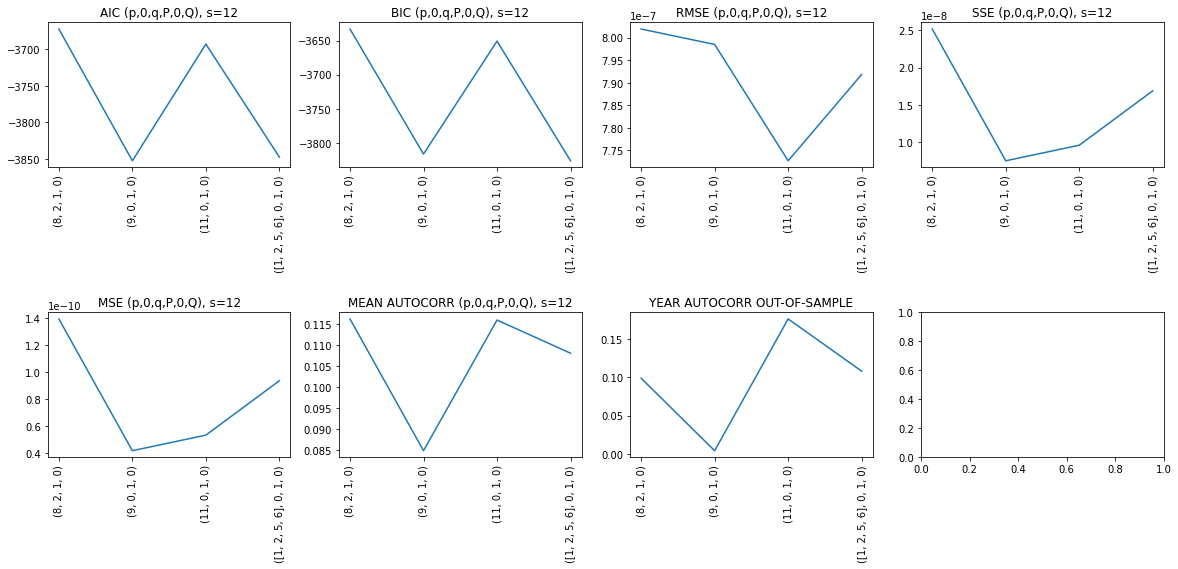

In [33]:
ticks = [tick(v['order'], v['seasonal_order']) for v in candidate_models]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,8))
indices = np.arange(0, len(candidate_models), 1)

fig.subplots_adjust(hspace=1)

axs[0,0].plot(aics)
axs[0,0].set_title('AIC (p,0,q,P,0,Q), s=12')
axs[0,0].set_xticks(indices)
axs[0,0].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[0,1].plot(bics)
axs[0,1].set_title('BIC (p,0,q,P,0,Q), s=12')
axs[0,1].set_xticks(indices)
axs[0,1].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[0,2].plot(rmses)
axs[0,2].set_title('RMSE (p,0,q,P,0,Q), s=12')
axs[0,2].set_xticks(indices)
axs[0,2].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[0,3].plot(sses)
axs[0,3].set_title('SSE (p,0,q,P,0,Q), s=12')
axs[0,3].set_xticks(indices)
axs[0,3].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[1,0].plot(mses)
axs[1,0].set_title('MSE (p,0,q,P,0,Q), s=12')
axs[1,0].set_xticks(indices)
axs[1,0].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[1,1].plot(maacf)
axs[1,1].set_title('MEAN AUTOCORR (p,0,q,P,0,Q), s=12')
axs[1,1].set_xticks(indices)
axs[1,1].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[1,2].plot(yac_out_of_sample)
axs[1,2].set_title('YEAR AUTOCORR OUT-OF-SAMPLE')
axs[1,2].set_xticks(indices)
axs[1,2].set_xticklabels(np.array(ticks)[indices], rotation=90)


plt.show()